In [58]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import os
import data_science_functions as ds
import project_tools as pt
from glob import glob as glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd

**Table of contents**<a id='toc0_'></a>    
- 1. [Images caracteristics](#toc1_)    
- 2. [Discovering SIFT on one image](#toc2_)    
- 3. [On the dataset](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Images caracteristics

In [26]:
filenames = glob('./data/Flipkart/Images/*')
filenames[:5]

['./data/Flipkart/Images/968a2b3be84193e3f755c2fe71033a2c.jpg',
 './data/Flipkart/Images/55ce1309b69e1912d2fd60a3ee3f351b.jpg',
 './data/Flipkart/Images/9a0413117aa91c668ba5944770347cc5.jpg',
 './data/Flipkart/Images/bc2aaae47829fd5825f6cc2ec51c2c5f.jpg',
 './data/Flipkart/Images/2f40e01331bc00216d147d4ebfdfbaf3.jpg']

In [29]:
from collections import defaultdict
metadata = defaultdict()

# Compute basic information about images.
for filename in filenames:
    img = cv.imread(filename=filename)
    gray_img= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    shape_ = img.shape
    metadata[filename] = {
        'shape': shape_,
        'n_pixels': shape_[0] * shape_[1],
        'mean_gray': np.mean(img),
        'min_gray': np.min(img),
        'max_gray': np.max(img),
    }

In [121]:
# Convert to dataframe and change index to the image name
metadata = pd.DataFrame(metadata).T
metadata['image'] = (
    pd.Series(metadata.index)
    .str.split('/', expand=True)[4]
    .values
)
metadata = metadata.set_index('image')

In [4]:
metadata.head()

,shape,n_pixels,mean_gray,min_gray,max_gray
image,,,,,
968a2b3be84193e3f755c2fe71033a2c.jpg,"(1100, 985, 3)",1083500,192.156326,0,255
55ce1309b69e1912d2fd60a3ee3f351b.jpg,"(1249, 1255, 3)",1567495,163.569048,0,255
9a0413117aa91c668ba5944770347cc5.jpg,"(630, 1100, 3)",693000,245.747279,0,255
bc2aaae47829fd5825f6cc2ec51c2c5f.jpg,"(1100, 501, 3)",551100,243.137071,0,255
2f40e01331bc00216d147d4ebfdfbaf3.jpg,"(1100, 682, 3)",750200,224.802873,0,255


In [6]:
# Retrieve information of the images' category
text_data_path = 'data/Flipkart/flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(text_data_path)
categories = df.product_category_tree.str.split(">>", expand=True)
categories.head()

,0,1,2,3,4,5,6
0,"[""Home Furnishing",Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,"[""Baby Care",Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,"[""Home Furnishing",Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,"[""Home Furnishing",Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None


In [10]:
# Format categories
df['category'] = (
    categories
    .loc[:, 0]
    .str.removeprefix('["')
    .str.lower()
    .str.rstrip(' ')
    .str.replace(' ', '_')
)

# Keep only relevant information
df = df[['image', 'category']]
df.head()

,image,category
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home_furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby_care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby_care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home_furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home_furnishing


In [9]:
# Merge medatadata and category
metadata = metadata.merge(df, how='left', on='image')
metadata = metadata.reset_index().sort_values('image')
metadata.head()

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
366,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
86,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
250,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
71,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
768,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


In [10]:
# metadata.to_csv('./data/Flipkart/Images/metadata.csv.gz', index=False)

In [11]:
metadata = pd.read_csv('./data/Flipkart/Images/metadata.csv.gz',
                       index_col='image')

metadata = metadata.reset_index().sort_values('image')
metadata.head()

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


In [12]:
metadata.reset_index()['image'].str.split('.', expand=True)[1].value_counts()

1
jpg    1050
Name: count, dtype: int64

In [13]:
metadata.describe()

,n_pixels,mean_gray,min_gray,max_gray
count,1.050000e+03,1050.000000,1050.000000,1050.000000
mean,1.916300e+06,175.125888,2.451429,254.986667
std,3.919232e+06,40.545367,11.342153,0.351781
min,5.800000e+04,26.426799,0.000000,244.000000
25%,6.723750e+05,149.649473,0.000000,255.000000
50%,1.015850e+06,179.871549,0.000000,255.000000
75%,1.553940e+06,205.881855,0.000000,255.000000
max,9.368033e+07,254.087186,220.000000,255.000000


In [48]:
# Smallest image
metadata.query('n_pixels == 58000')

,shape,n_pixels,mean_gray,min_gray,max_gray,category
image,,,,,,
3b0f02b3acf1825f8bbc1fb3b860dbb8.jpg,"(400, 145, 3)",58000,195.264397,0,255,kitchen_&_dining


In [54]:
metadata.query('min_gray > 70')

,shape,n_pixels,mean_gray,min_gray,max_gray,category
image,,,,,,
11f06dffebf7edf9e15351834a190c2c.jpg,"(776, 1100, 3)",853600,232.429237,77,255,baby_care
0991e8d8f884003ab18890971191085d.jpg,"(364, 700, 3)",254800,233.896966,80,255,baby_care
9743e6d1c9f3180483825fe4d2e97836.jpg,"(541, 534, 3)",288894,243.698123,220,255,computers
3b80ac036843b278083fabfd9a3c84ff.jpg,"(1100, 981, 3)",1079100,209.831746,79,255,kitchen_&_dining
c8e2c85eccdc9db55eeb2231385e4f1c.jpg,"(1100, 381, 3)",419100,245.331656,99,255,computers


- All files are jpg. 

- Contrast can be improved before computing SIFT because some images do not use low values of gray.

- No need for resizing and cropping except if we encounter time computation difficulties because SIFT manages different scales.

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Discovering opencv and SIFT on one image

(1162, 687, 3)


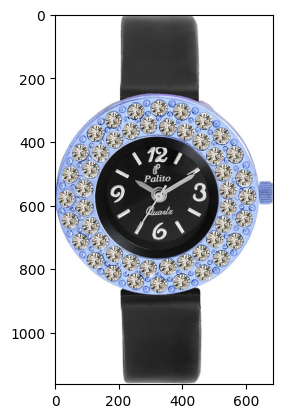

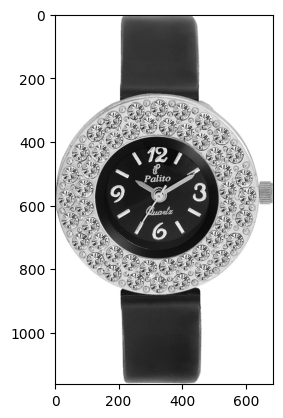

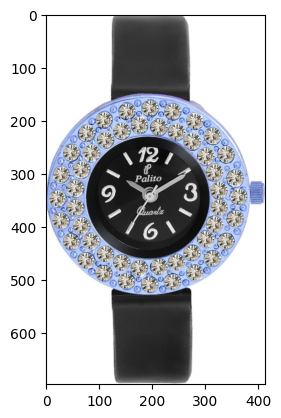

(697, 412, 3)


In [19]:
# Open and convert one image in the GRAYSCALE format
img = cv.imread(filename=filenames[0])
gray_img= cv.cvtColor(img,cv.COLOR_BGR2GRAY)

print(img.shape)
plt.imshow(img)
plt.show()
plt.imshow(gray_img, cmap='gray', vmin=0, vmax=255)
plt.show()

scale_percent = 60 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
plt.imshow(resized)
plt.show()
print(resized.shape)


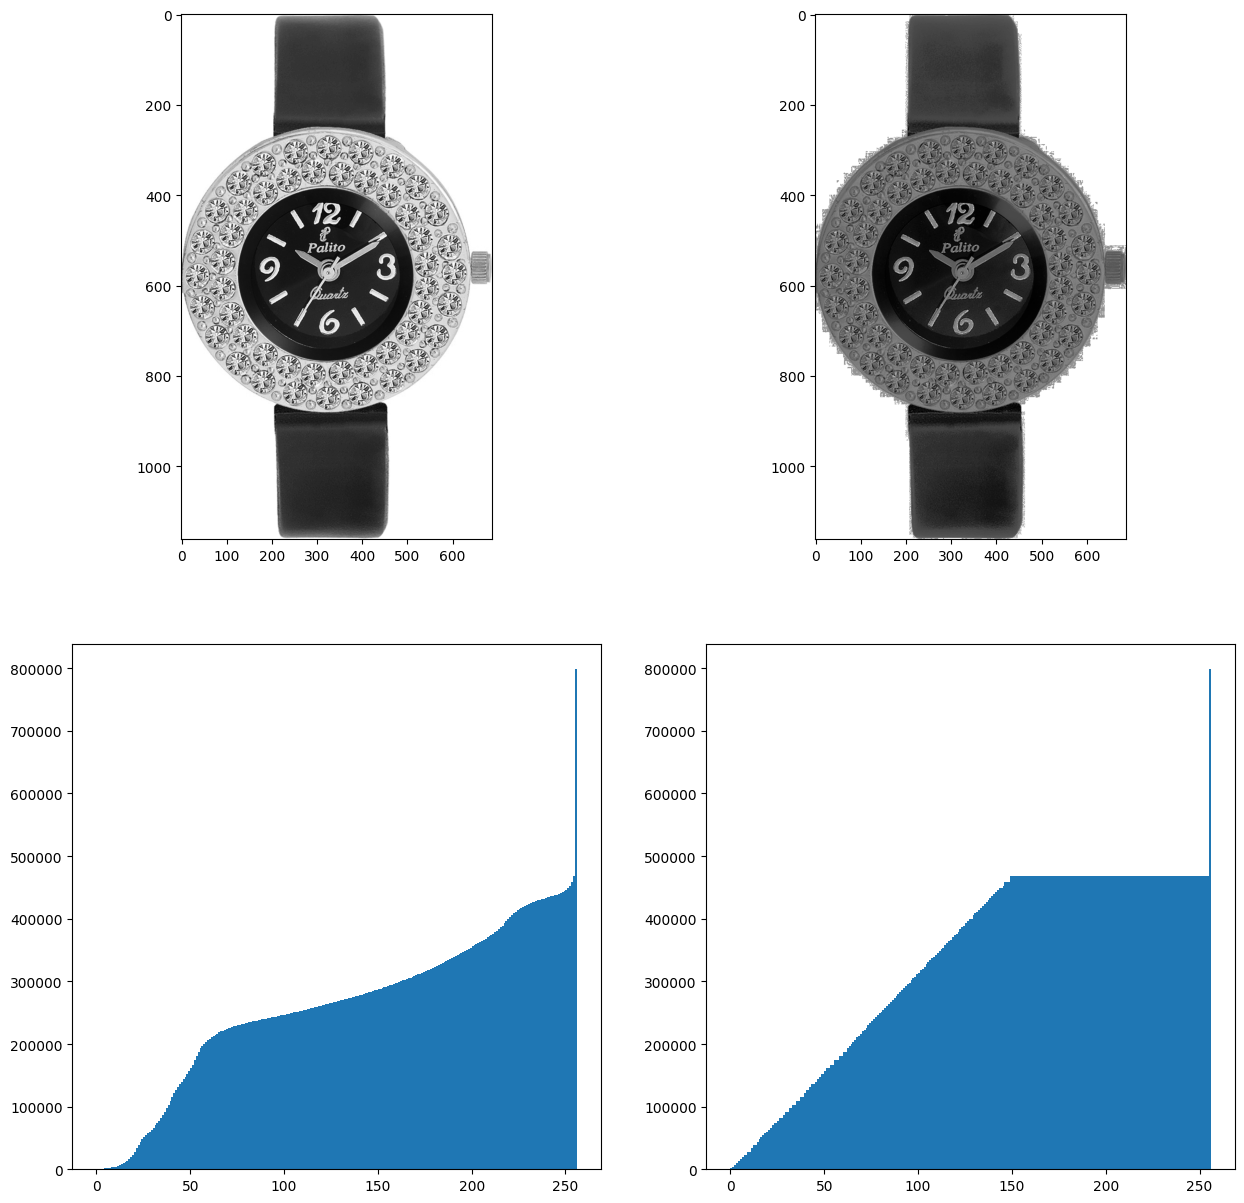

In [20]:
# Trying histogram equalization
eq_img = cv.equalizeHist(gray_img)
hist = cv.calcHist([gray_img],[0],None,[256],[0,256])
eq_hist = cv.calcHist([eq_img],[0],None,[256],[0,256])

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

ax[0,0].imshow(gray_img, cmap='gray', vmin=0, vmax=255)
ax[0,1].imshow(eq_img, cmap='gray', vmin=0, vmax=255)
ax[1,0].hist(gray_img.ravel(), 256, [0,256], log=False, cumulative=True)
ax[1,1].hist(eq_img.ravel(), 256, [0,256], log=False, cumulative=True)

plt.show()

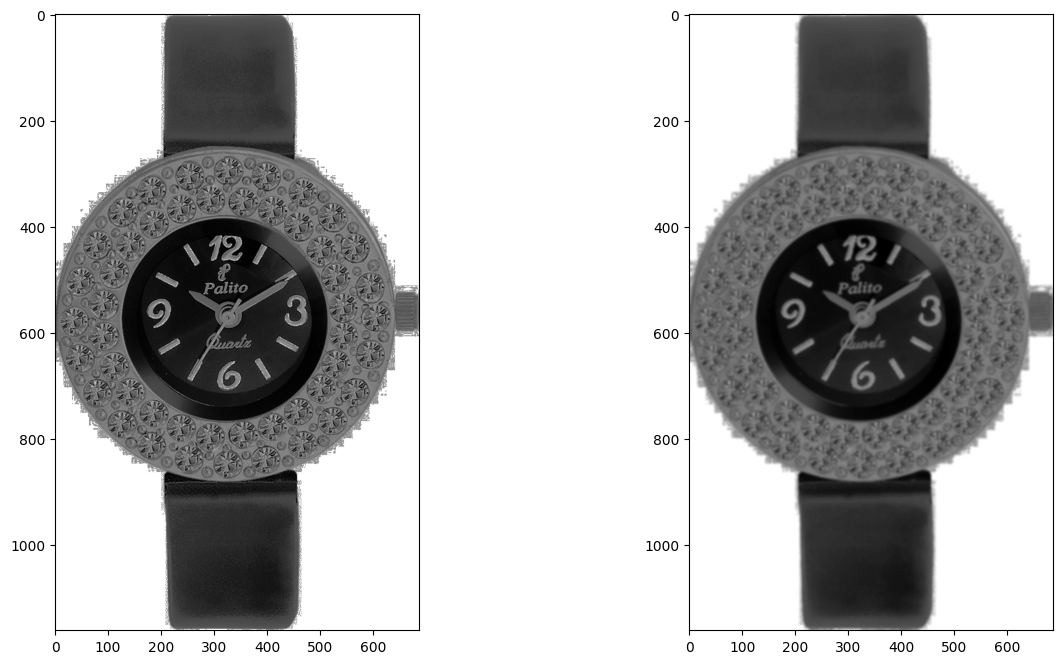

In [21]:
# Smoothen noise with a gaussian filter
blur_eq_img = cv.GaussianBlur(eq_img,(11,11),0)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(eq_img, cmap='gray')
ax[1].imshow(blur_eq_img, cmap='gray')

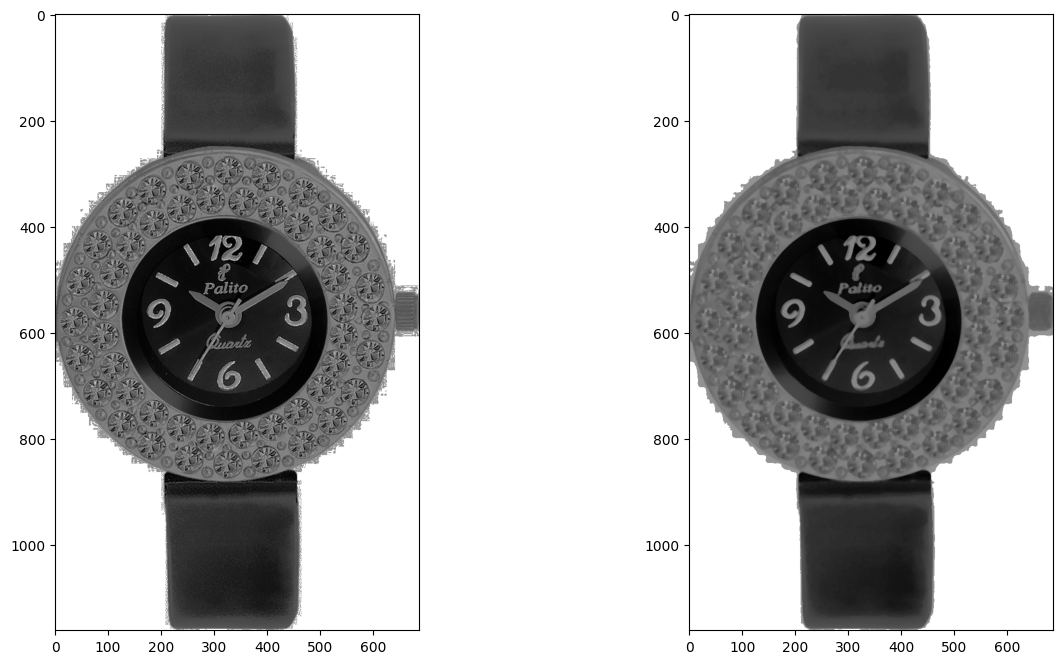

In [22]:
# Smoothen noise with a median filter
blur_eq_img = cv.medianBlur(eq_img, 7)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(eq_img, cmap='gray')
ax[1].imshow(blur_eq_img, cmap='gray')

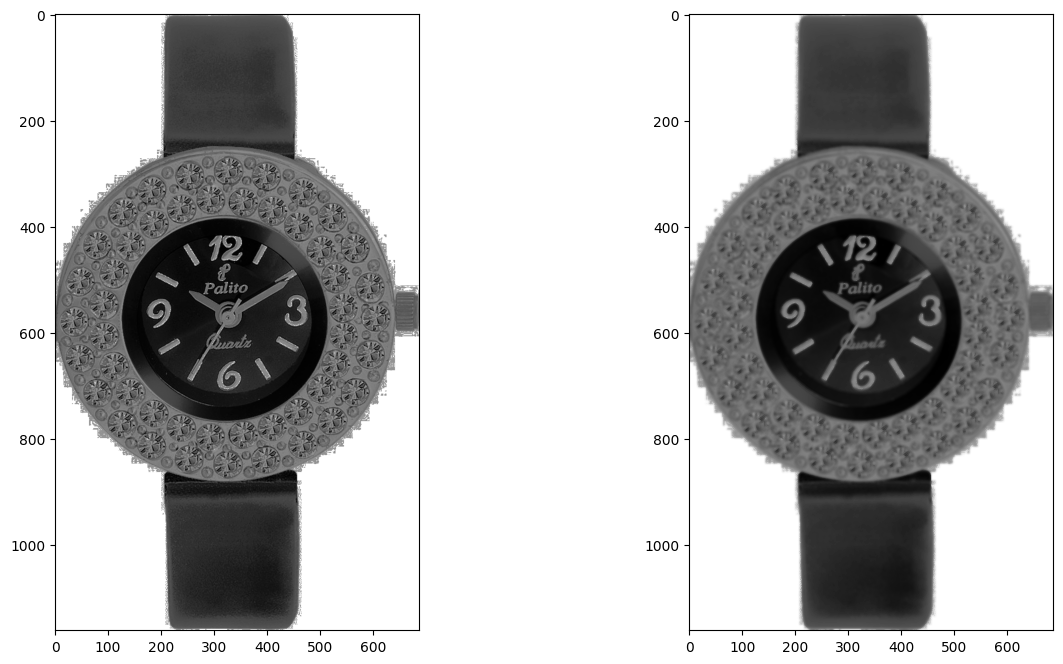

In [26]:
# Smoothen noise with a bilateral filter (longer to compute)
blur_eq_img = cv.bilateralFilter(eq_img, 9,100,100)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(eq_img, cmap='gray')
ax[1].imshow(blur_eq_img, cmap='gray')

Number of keypoints Detected: 300 



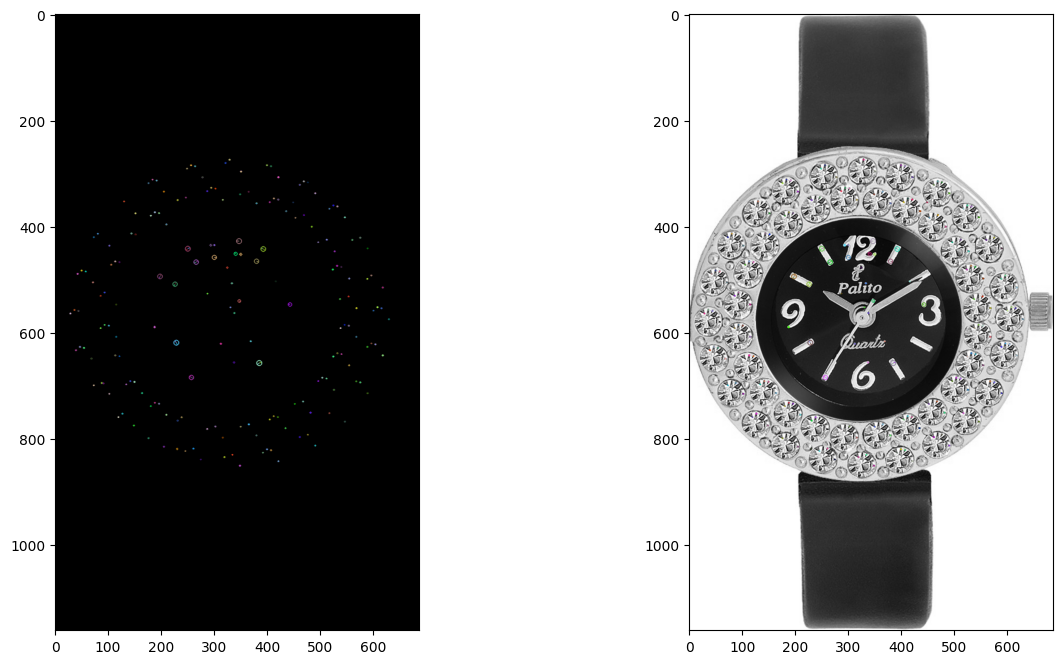

In [30]:
# SIFT is a feature detector and descriptor

# Initiate SIFT detector to detect a maximum of nfeatures
SIFT = cv.SIFT_create(nfeatures=300)

# Find the keypoints with SIFT
keypoints = SIFT.detect(gray_img, None)

# Print number of keypoints detected
print("Number of keypoints Detected:", len(keypoints), "\n")

# Creating image of solid color with same size as image
mask = np.zeros((img.shape[0], img.shape[1]), np.uint8) 


# Drawing keypoints on a black image
black_kp = cv.drawKeypoints(image=mask,
                            keypoints=keypoints,
                            outImage=0,
                            flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

img_kp = cv.drawKeypoints(image=gray_img,
                          keypoints=keypoints,
                          outImage=0,
                          flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(black_kp)
ax[1].imshow(img_kp)
plt.show()

In [75]:
# Compute descriptors
_, descriptors = SIFT.compute(gray_img, keypoints)
descriptors.shape

(301, 128)

In [80]:
# test vertical stack to add features for later clustering
np.vstack([descriptors, descriptors]).shape

(602, 128)

In [35]:
min(resized.shape[:2])

412

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a> SIFT descriptors on all the images in the dataset.

In [115]:
# metadata.to_csv('./data/Flipkart/Images/metadata.csv.gz', index=False)
metadata = pd.read_csv('./data/Flipkart/Images/metadata.csv.gz')
metadata.head()

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers


In [116]:
# Need to add *.jpg to avoid picking the metadata file.
# Also need to sort to ensure compatibility with the above df.
filenames = sorted(glob('./data/Flipkart/Images/*.jpg'))
filenames[:5]

['./data/Flipkart/Images/009099b1f6e1e8f893ec29a7023153c4.jpg',
 './data/Flipkart/Images/0096e89cc25a8b96fb9808716406fe94.jpg',
 './data/Flipkart/Images/00cbbc837d340fa163d11e169fbdb952.jpg',
 './data/Flipkart/Images/00d84a518e0550612fcfcba3b02b6255.jpg',
 './data/Flipkart/Images/00e966a5049a262cfc72e6bbf68b80e7.jpg']

In [117]:
from tqdm import tqdm
# List which will receive all descriptors of all images 
# to fit a clusterer and map each descriptor to a class.
descriptors_list = []

# Limit to the main 'nfeatures' descriptors per image.
sift = cv.SIFT_create(nfeatures=100)

for filename in tqdm(filenames):
    # Read image and convert to gray
    img = cv.imread(filename=filename)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    # Resize without changing shape
    img = pt.resize_based_on_lowest_dimension(img, n_pixels=200)
        
    # Find the keypoints with SIFT
    _, descriptors = sift.detectAndCompute(img, None)
    descriptors_list.append(descriptors)

100%|██████████| 1050/1050 [00:58<00:00, 17.94it/s]


In [118]:
# Make some metadata on descriptors
n_descriptors = []

for desc in descriptors_list:
    if desc is None:
        n_descriptors.append(0)
    else:
        n_descriptors.append(desc.shape[0])

metadata['n_descriptors'] = n_descriptors
metadata.head()

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category,n_descriptors
0,009099b1f6e1e8f893ec29a7023153c4.jpg,"(1162, 687, 3)",798294,172.415863,0,255,watches,101
1,0096e89cc25a8b96fb9808716406fe94.jpg,"(904, 1478, 3)",1336112,156.565580,0,255,kitchen_&_dining,74
2,00cbbc837d340fa163d11e169fbdb952.jpg,"(326, 1347, 3)",439122,192.004357,9,255,home_furnishing,100
3,00d84a518e0550612fcfcba3b02b6255.jpg,"(857, 1100, 3)",942700,168.342569,0,255,beauty_and_personal_care,100
4,00e966a5049a262cfc72e6bbf68b80e7.jpg,"(1100, 962, 3)",1058200,171.585655,3,255,computers,100


In [119]:
metadata.n_descriptors.describe()

count    1050.000000
mean       92.043810
std        20.105584
min         0.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       103.000000
Name: n_descriptors, dtype: float64

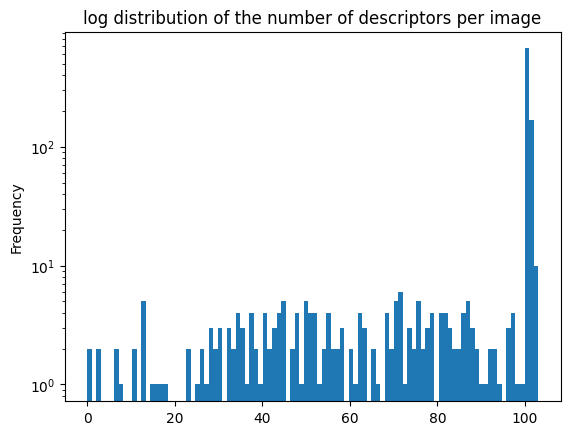

In [120]:
metadata.n_descriptors.plot(kind='hist', bins=100, log=True)
plt.title('log distribution of the number of descriptors per image')
plt.show()

In [121]:
no_descriptor = metadata.query('n_descriptors == 0')
no_descriptor

,image,shape,n_pixels,mean_gray,min_gray,max_gray,category,n_descriptors
123,227fc5c4fca14c424ff33e40941d22fa.jpg,"(863, 1132, 3)",976916,240.996633,0,255,baby_care,0
635,9743e6d1c9f3180483825fe4d2e97836.jpg,"(541, 534, 3)",288894,243.698123,220,255,computers,0


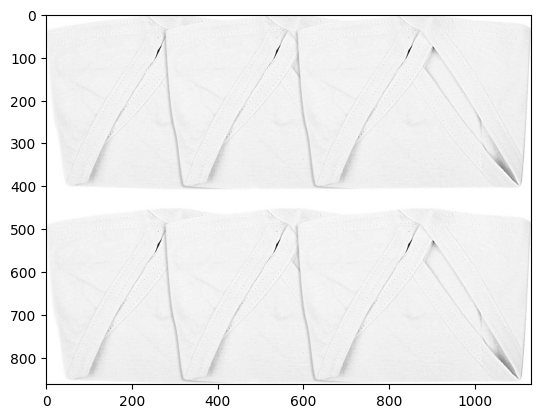

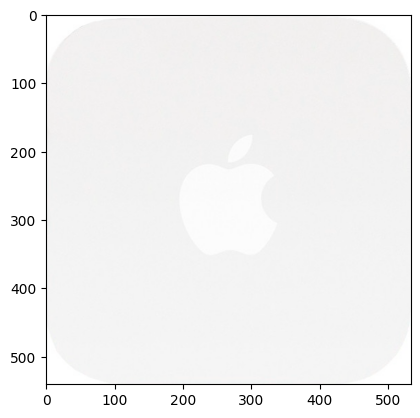

In [93]:
# Visualize images with no descriptors
image_dir = './data/Flipkart/Images/'

for name in no_descriptor.index:
    fig = plt.figure()
    img = cv.imread(image_dir + name)
    plt.imshow(img)

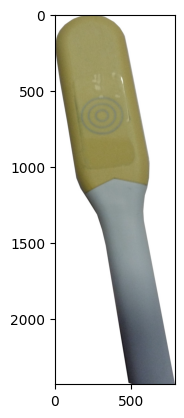

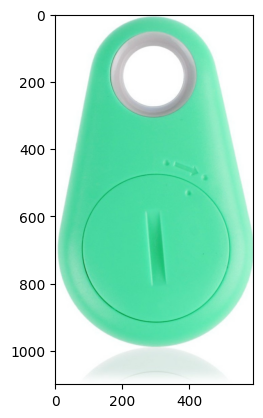

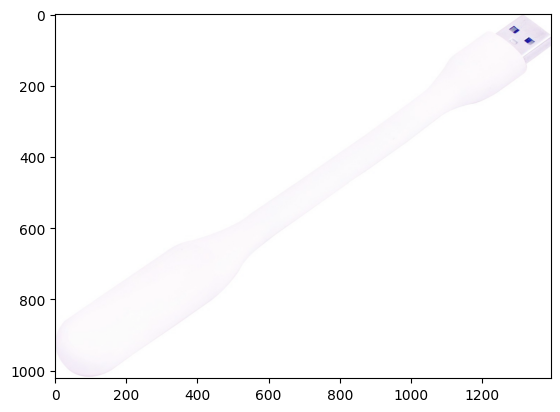

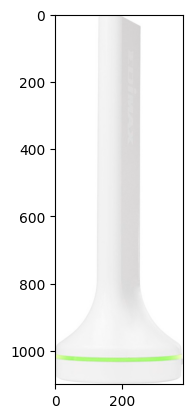

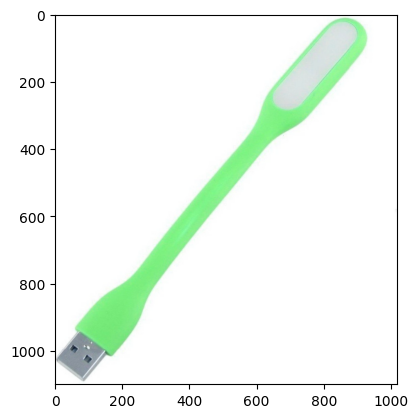

In [94]:
low_descriptors = metadata.query('0 < n_descriptors < 10')
# Visualize images with less than 10 descriptors
image_dir = './data/Flipkart/Images/'

for name in low_descriptors.index:
    fig = plt.figure()
    img = cv.imread(image_dir + name)
    plt.imshow(img)

Note :
- May be I could add some pre-processing to images and it would help find some descriptors in those images.

In [95]:
# # Create a matrix of all descriptors
# all_descriptors = np.vstack(descriptors_list)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 128 and the array at index 123 has size 1

In [187]:
# Add descriptors filled with zeros for images with no descriptors
idx_pb = no_descriptor.index
for idx in idx_pb:
    descriptors_list[idx] = np.zeros(128)[np.newaxis, :]

In [188]:
# Create a matrix of all descriptors
all_descriptors = np.vstack(descriptors_list)
all_descriptors.shape

(96648, 128)

Let's see if we see some tendencies in a sample of those descriptors.

In [130]:
tsne = TSNE(n_components=2, perplexity=60)
X_tsne = tsne.fit_transform(all_descriptors[:3000])

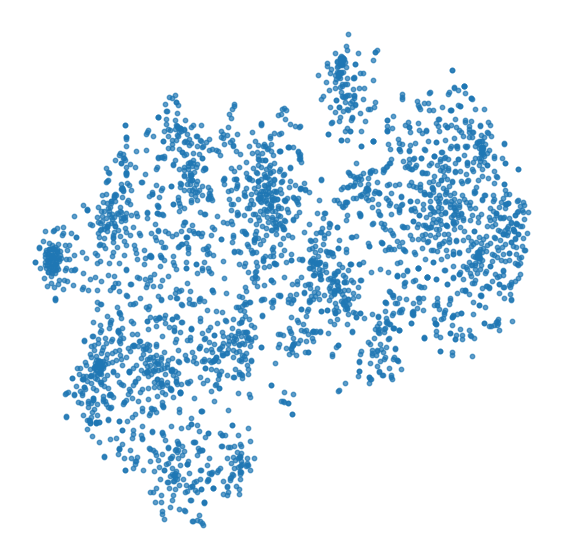

In [131]:
ds.display_tsne(X_tsne)

We can see some.

# Create image vectors

## Bag of features

We have about 100 000 descriptors.

I want to gather descriptors in classes. This will then help to characterize the image content by counting how many individuals of each classes are encountered among the descriptors of the image.

2 rules of thumb for choosing the number of clusters :
- n_category * 10 --> 70
- sqrt(n_descriptors) --> 100

I'm going for the mean : 85.

In [189]:
n_clusters = 85

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters, n_init=5)
# kmeans = MiniBatchKMeans(
#     n_clusters=n_clusters,
#     batch_size=1024,
#     verbose=1,
#     n_init=5
# )

kmeans.fit(all_descriptors)


KMeans(n_clusters=85, n_init=5)

## Build the image vector for the first image

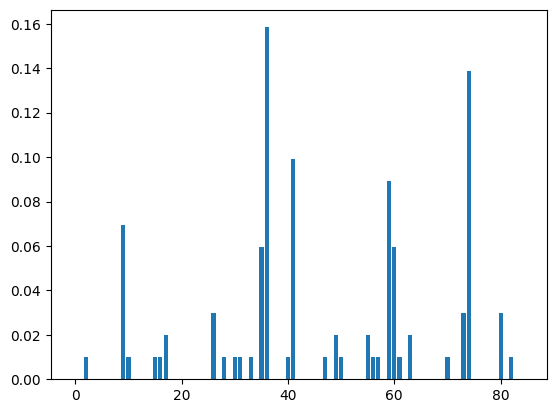

array([0.        , 0.        , 0.00990099, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.06930693,
       0.00990099, 0.        , 0.        , 0.        , 0.        ,
       0.00990099, 0.00990099, 0.01980198, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02970297, 0.        , 0.00990099, 0.        ,
       0.00990099, 0.00990099, 0.        , 0.00990099, 0.        ,
       0.05940594, 0.15841584, 0.        , 0.        , 0.        ,
       0.00990099, 0.0990099 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00990099, 0.        , 0.01980198,
       0.00990099, 0.        , 0.        , 0.        , 0.        ,
       0.01980198, 0.00990099, 0.00990099, 0.        , 0.08910891,
       0.05940594, 0.00990099, 0.        , 0.01980198, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00990099, 0.        , 0.        , 0.02970297, 0.13861

In [198]:
img_descriptors = descriptors_list[0]

img_vect = pt.create_image_vector_from_sift_descriptors(
    img_descriptors,
    kmeans,
)
        
plt.bar(range(n_clusters), img_vect)
plt.show()
img_vect

## Image vectors on the full dataset.

In [199]:
from collections import defaultdict

histo = defaultdict()
myzip = zip(descriptors_list, metadata.image,)

for img_descriptors, image_name in tqdm(myzip):
    histo[image_name] = pt.create_image_vector_from_sift_descriptors(
        img_descriptors=img_descriptors,
        fit_kmeans=kmeans,
    )
    
    

1050it [00:00, 1786.79it/s]


In [203]:
image_vectors = pd.DataFrame(
    histo,
    index=[f'feature_class_{k}' for k in range(n_clusters)]
).T

image_vectors.head()

,feature_class_0,feature_class_1,feature_class_2,feature_class_3,feature_class_4,feature_class_5,feature_class_6,feature_class_7,feature_class_8,feature_class_9,...,feature_class_75,feature_class_76,feature_class_77,feature_class_78,feature_class_79,feature_class_80,feature_class_81,feature_class_82,feature_class_83,feature_class_84
009099b1f6e1e8f893ec29a7023153c4.jpg,0.00,0.000000,0.009901,0.0,0.00,0.0,0.00,0.0,0.00,0.069307,...,0.00,0.00,0.00,0.0,0.0,0.029703,0.000000,0.009901,0.000000,0.00
0096e89cc25a8b96fb9808716406fe94.jpg,0.00,0.081081,0.000000,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,...,0.00,0.00,0.00,0.0,0.0,0.000000,0.013514,0.000000,0.013514,0.00
00cbbc837d340fa163d11e169fbdb952.jpg,0.04,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0,0.00,0.000000,...,0.00,0.01,0.00,0.0,0.0,0.000000,0.290000,0.000000,0.000000,0.00
00d84a518e0550612fcfcba3b02b6255.jpg,0.03,0.010000,0.000000,0.0,0.09,0.0,0.02,0.0,0.01,0.000000,...,0.03,0.01,0.01,0.0,0.0,0.030000,0.010000,0.000000,0.010000,0.01
00e966a5049a262cfc72e6bbf68b80e7.jpg,0.01,0.000000,0.000000,0.0,0.11,0.0,0.03,0.0,0.00,0.010000,...,0.00,0.01,0.00,0.0,0.0,0.000000,0.040000,0.000000,0.000000,0.00


In [206]:
image_vectors.to_csv('./data/Flipkart/Images/image_vectors.csv.gz')

In [207]:
!ls ./data/Flipkart/Images/*.gz

./data/Flipkart/Images/image_vectors.csv.gz
./data/Flipkart/Images/metadata.csv.gz


In [ ]:
# Reduce information and compute t-SNE
pca = PCA(n_components=0.99)
tsne = TSNE(n_components=2, perplexity=30)
X_tsne = tsne.fit_transform(pca.fit_transform(descriptors))
pca.n_components_
ds.display_tsne(X_tsne)